# 輪郭（エッジ）抽出

In [1]:
from PIL import Image, ImageFilter
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# im1 = Image.open("./data/city-3021474_1920.jpg")
im1 = Image.open("data/emotions-4637323_1920.jpg")
im1_small = im1.resize((int(1920/2), int(1280/2)))
im1_gray = im1_small.convert('L')

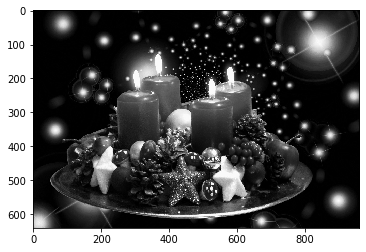

In [3]:
plt.imshow(im1_gray, cmap='gray')

In [4]:
# 5*5 blur
_kernel = np.array([[1,  4,  6,  4, 1],
                    [4, 16, 24, 16, 4],
                    [6, 24, 36, 24, 6],
                    [4, 16, 24, 16, 4],
                    [1,  4,  6,  4, 1]])/255
# _kernel = np.ones((5,5))/25
kernel = ImageFilter.Kernel(size=(5,5), kernel=_kernel.flatten(), scale=1)
im1_gaussian = im1_gray.filter(kernel)

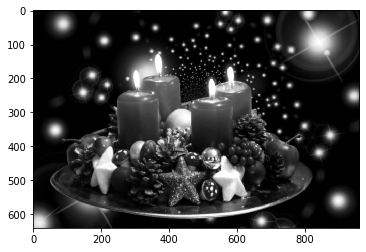

In [5]:
plt.imshow(im1_gaussian, cmap='gray')

## ソーベルフィルターによるエッジ検出

ソーベルフィルターを用意

In [6]:
# 横方向のソーベルフィルタ
kernel_x = np.array([[-1, 0, 1],
                     [-2, 0, 2],
                     [-1, 0, 1]])
kernel_x = ImageFilter.Kernel(size=(3,3), kernel=kernel_x.flatten(), scale=1)

# 縦方向のソーベルフィルタ
kernel_y = np.array([[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]])
kernel_y = ImageFilter.Kernel(size=(3,3), kernel=kernel_y.flatten(), scale=1)

画素値の勾配を取得

In [7]:
im1_sobel_x = np.array(im1_gray.filter(kernel_x)).astype(np.float)
im1_sobel_y = np.array(im1_gray.filter(kernel_y)).astype(np.float)
im1_sobel = np.sqrt(im1_sobel_x**2 + im1_sobel_y**2)

In [8]:
im1_edge_sobel = Image.fromarray(im1_sobel.astype(np.uint8))
im1_edge_sobel.save('data/task7/edge_detect_city.jpg', format="JPEG")

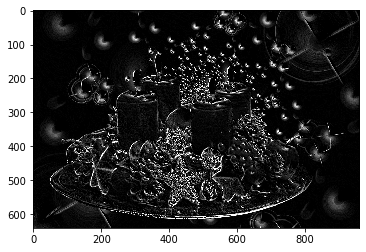

In [9]:
plt.imshow(im1_edge_sobel, cmap='gray')

In [10]:
im1_sobel_x = np.array(im1_gaussian.filter(kernel_x)).astype(np.float)
im1_sobel_y = np.array(im1_gaussian.filter(kernel_y)).astype(np.float)
im1_sobel = np.sqrt(im1_sobel_x**2 + im1_sobel_y**2)

In [11]:
im1_edge_sobel_blur = Image.fromarray(im1_sobel.astype(np.uint8))
im1_edge_sobel_blur.save('data/task7/edge_detect_blur_city.jpg', jpeg='JPEG')

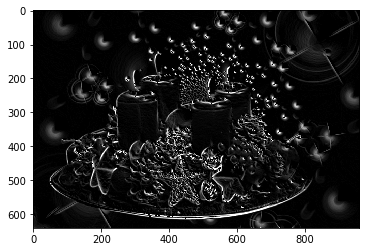

In [12]:
plt.imshow(im1_edge_sobel_blur, cmap='gray')

## キャニー法によるエッジ検出

In [13]:
im1_edge_sobel_blur_grad = np.arctan2(im1_sobel_y, im1_sobel_x)*180/np.pi # 輪郭の勾配

In [14]:
# Non maximum Suppression処理
def non_max_sup(G, Gth):

    h, w = G.shape
    dst = G.copy()

    # 勾配方向を4方向(垂直・水平・斜め右上・斜め左上)に近似
    Gth[np.where((Gth >= -22.5) & (Gth < 22.5))] = 0
    Gth[np.where((Gth >= 157.5) & (Gth < 180))] = 0
    Gth[np.where((Gth >= -180) & (Gth < -157.5))] = 0
    Gth[np.where((Gth >= 22.5) & (Gth < 67.5))] = 45
    Gth[np.where((Gth >= -157.5) & (Gth < -112.5))] = 45
    Gth[np.where((Gth >= 67.5) & (Gth < 112.5))] = 90
    Gth[np.where((Gth >= -112.5) & (Gth < -67.5))] = 90
    Gth[np.where((Gth >= 112.5) & (Gth < 157.5))] = 135
    Gth[np.where((Gth >= -67.5) & (Gth < -22.5))] = 135

    # 注目画素と勾配方向に隣接する2つの画素値を比較し、注目画素値が最大でなければ0に
    for y in range(1, h - 1):
        for x in range(1, w - 1):
            if Gth[y][x] == 0:
                if (G[y][x] < G[y][x+1]) or (G[y][x] < G[y][x-1]):
                    dst[y][x] = 0
            elif Gth[y][x] == 45:
                if (G[y][x] < G[y-1][x+1]) or (G[y][x] < G[y+1][x-1]):
                    dst[y][x] = 0
            elif Gth[y][x] == 90:
                if (G[y][x] < G[y+1][x]) or (G[y][x] < G[y-1][x]):
                    dst[y][x] = 0
            else:
                if (G[y][x] < G[y+1][x+1]) or (G[y][x] < G[y-1][x-1]):
                    dst[y][x] = 0
    return dst

In [15]:
# Hysteresis Threshold処理
def hysteresis_threshold(src, t_min=75, t_max=150, d=1):

    h, w = src.shape
    dst = src.copy()

    for y in range(0, h):
        for x in range(0, w):
            # 最大閾値より大きければ信頼性の高い輪郭
            if src[y][x] >= t_max:
                dst[y][x] = 255
            # 最小閾値より小さければ信頼性の低い輪郭(除去)
            elif src[y][x] < t_min:
                dst[y][x] = 0
            # 最小閾値～最大閾値の間なら、近傍に信頼性の高い輪郭が1つでもあれば輪郭と判定、無ければ除去
            else:
                idy = y-d if y-d >= 0 else 0
                idx = x-d if x-d >= 0 else 0
                if np.max(src[idy:y+d+1, idx:x+d+1]) >= t_max:
                    dst[y][x] = 255
                else:
                    dst[y][x] = 0

    return dst

In [16]:
t_min, t_max, d = 100, 200, 100

# 処理4 Non maximum Suppression処理
G = non_max_sup(np.array(im1_edge_sobel_blur), im1_edge_sobel_blur_grad)

# 処理5 Hysteresis Threshold処理
result = hysteresis_threshold(G, t_min, t_max, d)

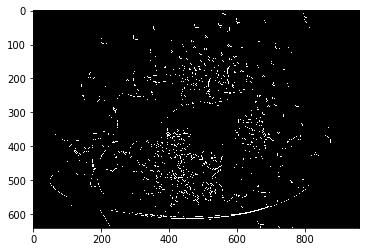

In [17]:
im1_edge_canny = Image.fromarray(result)
# im1_edge_canny.save('data/task7/edge_detect_canny.jpg', format="JPEG")
plt.imshow(im1_edge_canny,cmap='gray')